## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))


def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    aug_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    aug_loader = DataPrefetcher(aug_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    data.aug_dl = aug_loader
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x), inplace=True)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out), inplace=True))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, concatpool=False):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.pool = AdaptiveConcatPool2d() if concatpool else nn.AdaptiveMaxPool2d((1,1))
        
        self.linear = nn.Linear(512*block.expansion*(concatpool+1), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.adaptive_max_pool2d(out, 1)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

def preact_resnet18(): return PreActResNet(PreActBlock, [2,2,2,2])
def preact_resnet2332(): return PreActResNet(PreActBlock, [2,3,3,2])
def preact_resnet3333(): return PreActResNet(PreActBlock, [3,3,3,3])
def preact_resnet34(): return PreActResNet(PreActBlock, [3,4,6,3])
def preact_resnet50(): return PreActResNet(PreActBottleneck, [3,4,6,3])
def preActResNet101(): return PreActResNet(PreActBottleneck, [3,4,23,3])
def preActResNet152(): return PreActResNet(PreActBottleneck, [3,8,36,3])


In [7]:
# m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

In [8]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

def get_TTA_accuracy_2(learn):
    log_preds,y = learn.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)

In [9]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
learn.clip = 2e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.07,.5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.5,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.514362   1.833459   0.4271    
    1      1.204597   1.161866   0.6097                   
    2      0.99472    0.858239   0.705                     
    3      0.781386   1.028838   0.6548                    
    4      0.630311   0.770166   0.7423                    
    5      0.557596   0.581109   0.8034                    
    6      0.497293   0.597883   0.7889                    
    7      0.45293    0.639409   0.7869                    
    8      0.422581   0.569038   0.8161                    
    9      0.393059   0.527597   0.8229                    
    10     0.37662    0.447994   0.8485                    
    11     0.374499   0.709      0.7799                    
    12     0.343055   0.591252   0.8084                    
    13     0.322047   0.59038    0.8129                    
    14     0.324812   0.62103    0.7964                    
    15     0.292983   0.427286   0.8677                   

[array([0.24901]), 0.9317000016212463]

In [10]:
print(get_TTA_accuracy(learn), get_TTA_accuracy_2(learn))

TTA acc: 0.6612                              
0.6463 None


In [11]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
learn.clip = 2e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=7, lr=(.07,1), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(1,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.503406   1.709994   0.4382    
    1      1.17662    1.121714   0.6086                   
    2      0.969398   0.997713   0.658                     
    3      0.779492   0.736303   0.7484                    
    4      0.69281    1.692419   0.5436                    
    5      0.6334     0.676715   0.7657                    
    6      0.578578   1.136238   0.6512                    
    7      0.556495   0.77753    0.7641                    
    8      0.558767   0.695289   0.7688                    
    9      0.505807   0.696798   0.7679                    
    10     0.46629    0.953102   0.7158                    
    11     0.444898   0.494446   0.8307                    
    12     0.398989   0.733148   0.7756                    
    13     0.345743   0.531741   0.831                     
    14     0.280324   0.374518   0.871                     
    15     0.212221   0.267789   0.9113                   

[array([0.24667]), 0.9208999995231628]

In [15]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
learn.clip = 2e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=8, lr=(.07,1.2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(1.2,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=3, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.53224    1.820372   0.4342    
    1      1.18007    1.412231   0.5478                   
    2      1.067037   1.182038   0.6284                   
    3      0.820832   0.78923    0.7238                    
    4      0.690108   0.848793   0.7098                    
    5      0.656536   0.972672   0.6846                    
    6      0.609887   1.055164   0.6896                    
    7      0.604241   0.879049   0.7462                    
    8      0.629872   0.74159    0.7462                    
    9      0.617792   0.736781   0.7472                    
    10     0.552444   0.706589   0.7728                    
    11     0.510193   1.086827   0.6771                    
    12     0.45516    0.624216   0.8044                    
    13     0.424116   0.766907   0.7666                    
    14     0.367054   0.421222   0.8577                    
    15     0.311036   0.46417    0.8455                    

[array([0.24852]), 0.9194000020027161]

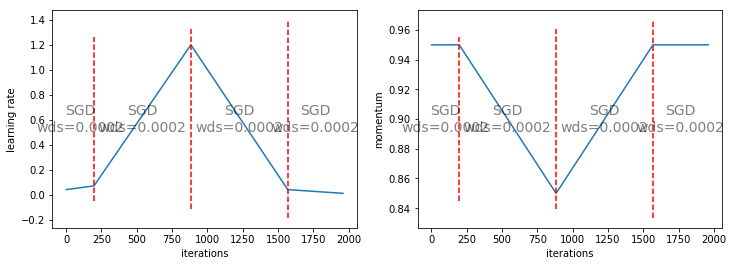

In [14]:
learn.sched.plot_lr()

In [16]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
learn.clip = 2e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .07), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=15, lr=(.07,1.2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(1.2,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=4, lr=(.04,.01), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.552279   1.814841   0.444     
    1      1.220112   1.345704   0.5795                   
    2      0.991489   1.907349   0.523                     
    3      0.829333   0.9819     0.6745                    
    4      0.700994   0.884175   0.7164                    
    5      0.615133   0.721208   0.7519                    
    6      0.589008   0.730216   0.7599                    
    7      0.563485   0.995293   0.6954                    
    8      0.546204   0.872527   0.707                     
    9      0.520879   0.616855   0.786                     
    10     0.554489   1.02798    0.6939                    
    11     0.52858    0.599669   0.7942                    
    12     0.514411   0.712558   0.7827                    
    13     0.510688   1.936078   0.6029                    
    14     0.485955   0.731484   0.7586                    
    15     0.498154   0.738961   0.7559                   

[array([0.21666]), 0.9347000017166137]

In [17]:
print(get_TTA_accuracy(learn), get_TTA_accuracy_2(learn))

TTA acc: 0.6647                              
0.6592 None


In [19]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.7), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.7,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(.04,.001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

 56%|█████▌    | 55/98 [00:04<00:03, 12.18it/s, loss=1.74]

Exception in thread Thread-429:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.526353   1.820021   0.4295    
    1      1.235569   1.117652   0.6113                   
    2      0.96428    0.870498   0.6883                    
    3      0.788418   0.852125   0.7271                    
    4      0.664687   0.829794   0.7408                    
    5      0.576005   0.854356   0.7473                    
    6      0.522569   1.107766   0.6958                    
    7      0.488322   0.604764   0.797                     
    8      0.462028   0.568659   0.8082                    
    9      0.435574   0.474272   0.8433                    
    10     0.432522   0.85334    0.7506                    
    11     0.40901    0.718758   0.7869                    
    12     0.395341   0.678083   0.7886                    
    13     0.385799   0.470976   0.8392                    
    14     0.37535    0.710054   0.792                     
    15     0.368233   0.60696    0.8069                   

[array([0.23034]), 0.9375999991416931]

In [ ]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=2e-4
lr=1.2
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(.04, .08), lr_decay=DecayType.LINEAR, momentum=0.95),
    TrainingPhase(**def_phase, epochs=13, lr=(.08,.7), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=13, lr=(.7,.04), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=7, lr=(.04,.001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

### END TESTING

In [ ]:
m = pre_resnet18()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [ ]:
learn.sched.plot_lr()

In [ ]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5
learn.clip = 3e-1
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)